In [ ]:
# Data Source: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

In [3]:
!pip install torchsummary

In [4]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

import time

from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

import torch.optim as optim
from torchvision import models           # for getting the summary of our model

%matplotlib inline

# LOADING TRAINING AND VALIDATION DATASET

In [5]:
data_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [5]:
# printing the disease names
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [6]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [7]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [9]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


In [10]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Bacterial_spot                                      1702
Apple___Black_rot                                            1987
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___Bacterial_spot                                       1838
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Grape___Black_rot                                            1888
Potato___Early_blight                                        1939
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Common_rust_                                  1907
Grape___Esca_(Black_Measles)                                 1920
Raspberry___healthy                                          1781
Tomato___Leaf_Mold                                           1882
Tomato___Spider_mites Two-spotted_spider_mite                1741
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___healthy                                       1859

Text(0.5, 1.0, 'Images per each class of plant disease')

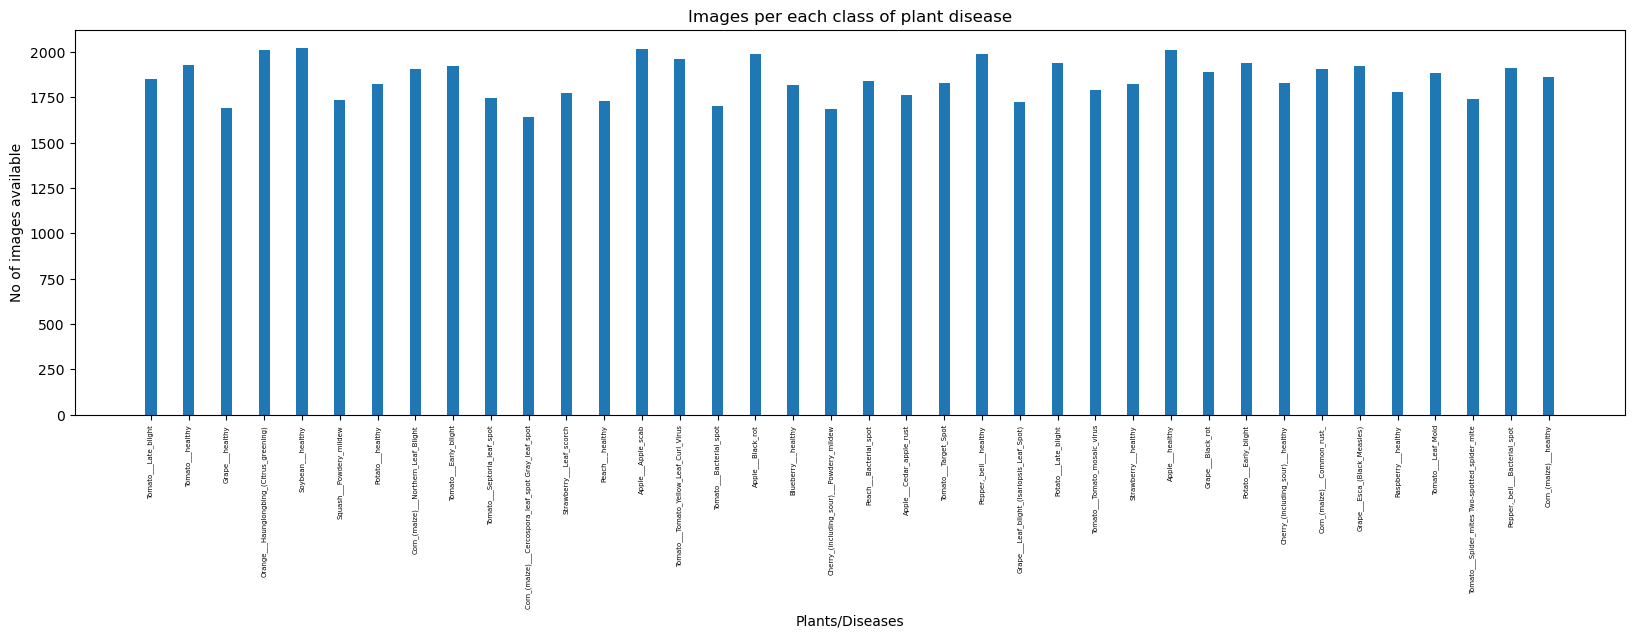

In [11]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [12]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


# PREPROCESSING DATASET

In [6]:
# Define transforms for data preprocessing
train_transform = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])



# Define transforms for data preprocessing
valid_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the image folder

train_dataset = ImageFolder(train_dir, transform=train_transform)
valid_dataset = ImageFolder(valid_dir, transform=valid_transform) 


In [14]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [15]:
# total number of classes in train set
len(train_dataset.classes)

38

In [7]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [8]:
# setting the batch size
batch_size = 32

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

In [18]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

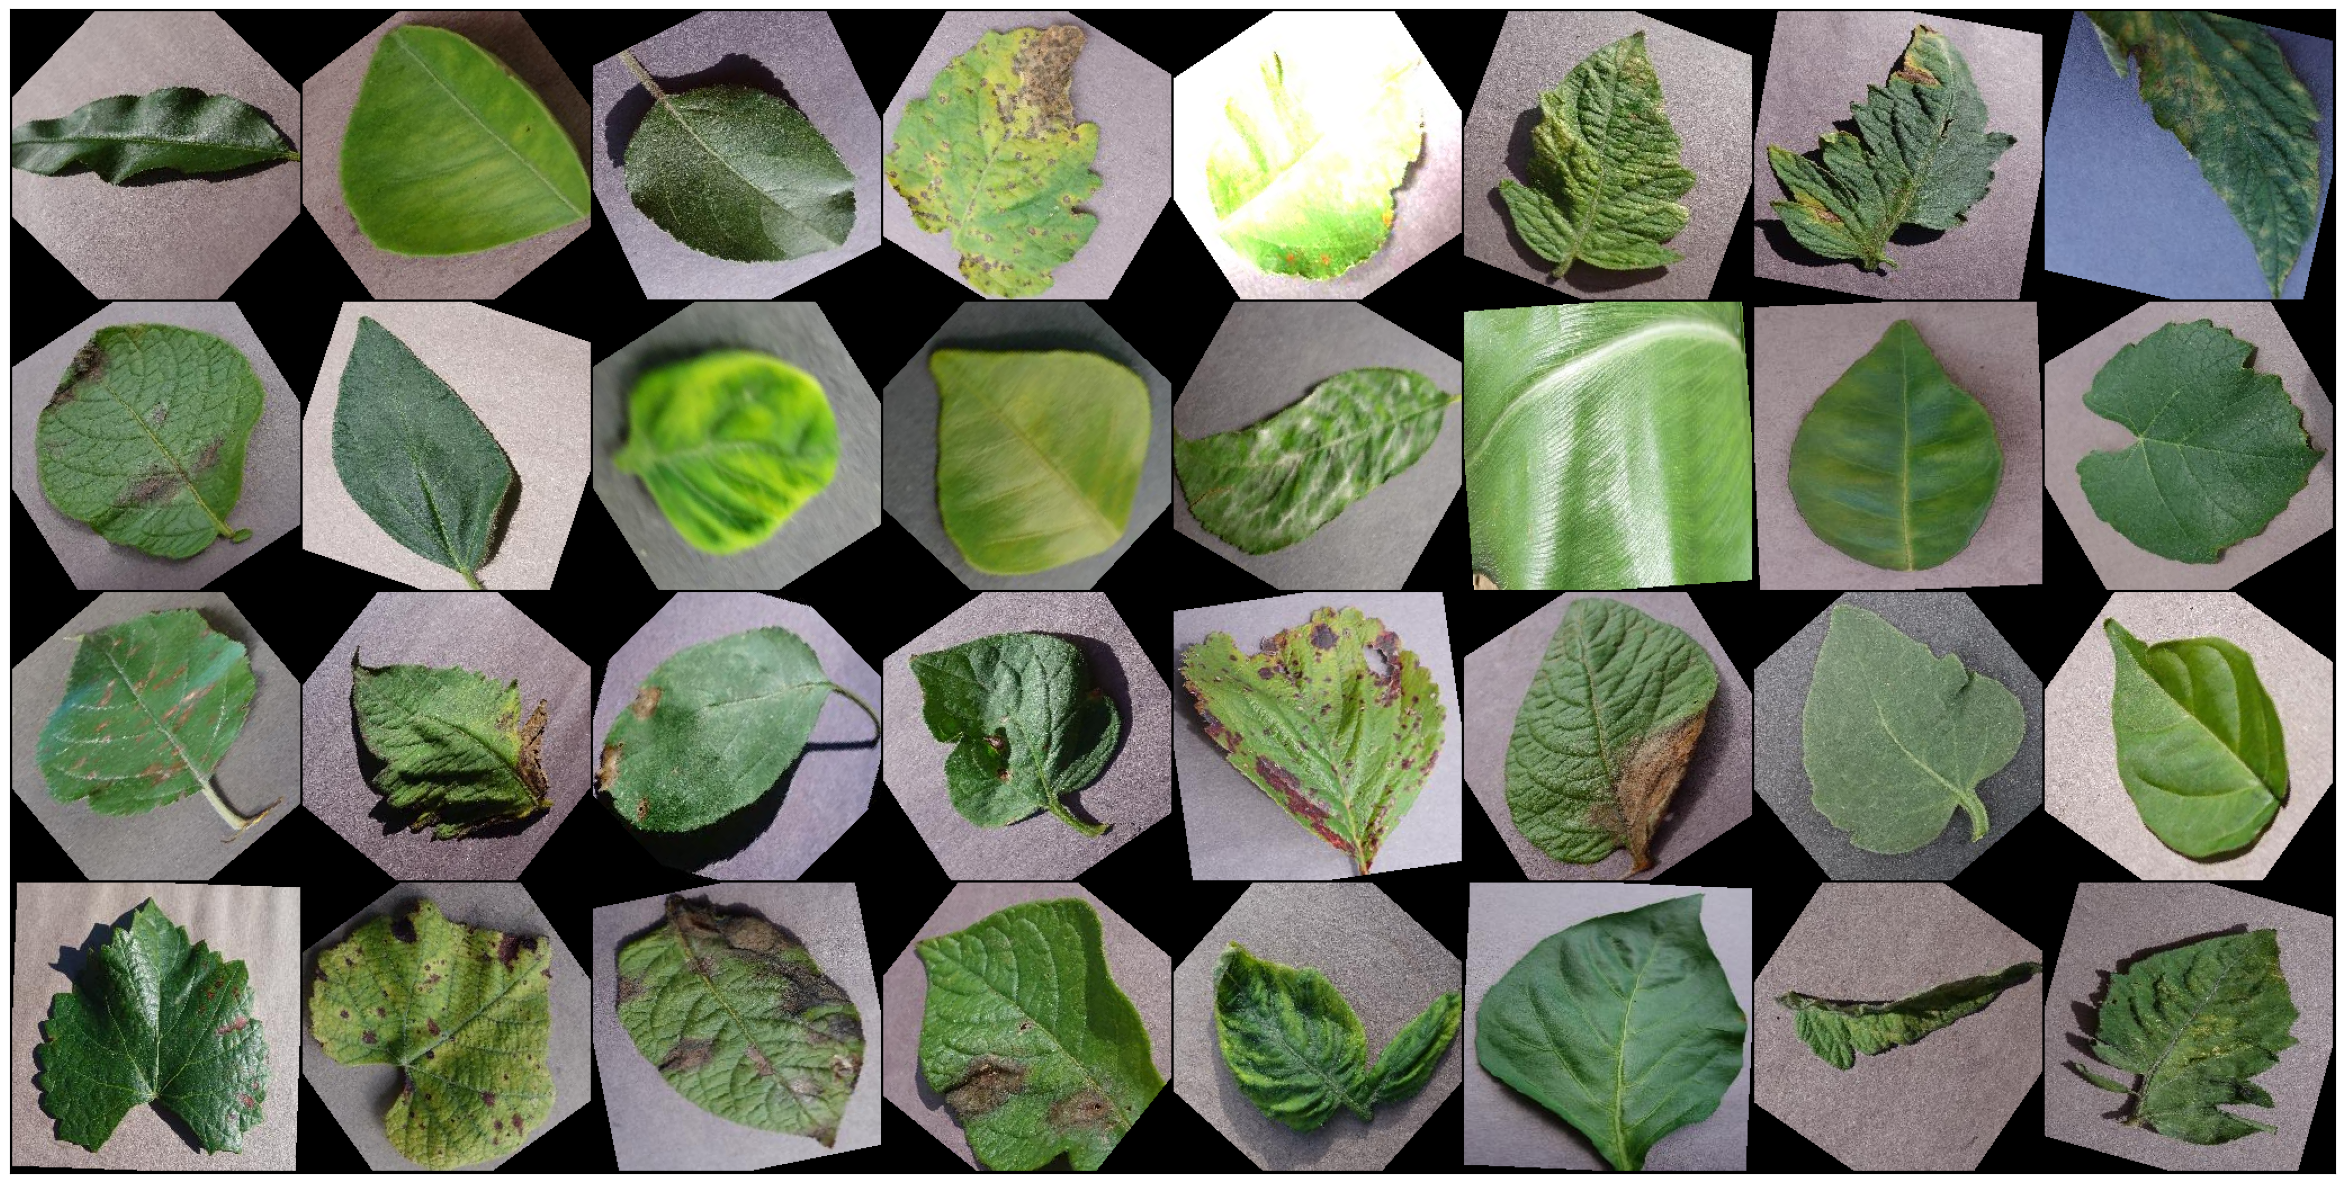

In [19]:
# Images for first batch of training
show_batch(train_loader) 

### LOADING TEST DATASET

In [9]:
test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [10]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

## DEFINING HELPER FUNCTIONS

In [48]:
# Training step
def train_step(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss /= len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    return train_loss, train_accuracy

In [49]:
# Validation step
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100.0 * correct / total
    
    return val_loss, val_accuracy

In [50]:

import time

# Training loop
def train(model, device, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    start_time = time.time()  # Record the start time of training
    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train_step(model, device, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate the model
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print train and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}]\n"
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n"
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
            # Get the current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
         # Print the learning rate for the current epoch
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n")
        
    end_time = time.time()  # Record the end time of training
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    
    print(f"Training completed in {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.0f} seconds")
        
        # Plot the training and validation curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    
    # Plot learning rate over epochs
    plt.plot(range(1, num_epochs+1), learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()
    
    

In [51]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train_dataset.classes[preds[0].item()]

In [52]:
# Prediction step
def predict(model, device, val_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.tolist())
            true_labels.extend(targets.tolist())

    return predictions, true_labels

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Residual Block (RESNET9) code implementation and training

In [28]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [29]:
in_channels = 3
num_diseases = len(train_dataset.classes)
num_diseases

38

In [30]:
resnet_model = ResNet9(in_channels, num_diseases).to(device)
resnet_model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [31]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(resnet_model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# TRAINING RESNET MODEL

In [32]:
learning_rate = 0.01
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

Epoch [1/30]
Train Loss: 1.3220, Train Accuracy: 66.17%
Val Loss: 0.3497, Val Accuracy: 88.93%

Learning Rate: 0.010000

Epoch [2/30]
Train Loss: 0.2510, Train Accuracy: 91.99%
Val Loss: 0.3194, Val Accuracy: 89.84%

Learning Rate: 0.010000

Epoch [3/30]
Train Loss: 0.1792, Train Accuracy: 94.34%
Val Loss: 0.2949, Val Accuracy: 91.09%

Learning Rate: 0.010000

Epoch [4/30]
Train Loss: 0.1509, Train Accuracy: 95.29%
Val Loss: 0.1384, Val Accuracy: 95.52%

Learning Rate: 0.010000

Epoch [5/30]
Train Loss: 0.1295, Train Accuracy: 95.95%
Val Loss: 0.2426, Val Accuracy: 93.42%

Learning Rate: 0.010000

Epoch [6/30]
Train Loss: 0.1177, Train Accuracy: 96.34%
Val Loss: 0.4332, Val Accuracy: 88.42%

Learning Rate: 0.010000

Epoch [7/30]
Train Loss: 0.1092, Train Accuracy: 96.78%
Val Loss: 0.1732, Val Accuracy: 95.19%

Learning Rate: 0.001000

Epoch [8/30]
Train Loss: 0.0324, Train Accuracy: 98.92%
Val Loss: 0.0222, Val Accuracy: 99.31%

Learning Rate: 0.001000

Epoch [9/30]
Train Loss: 0.0205,

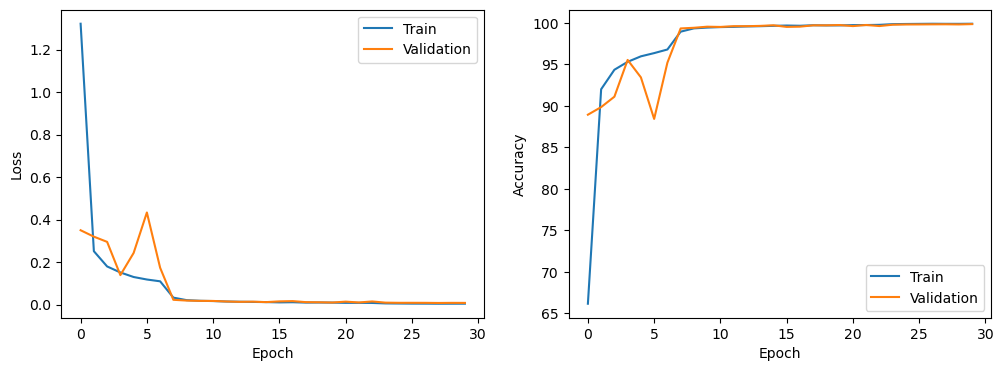

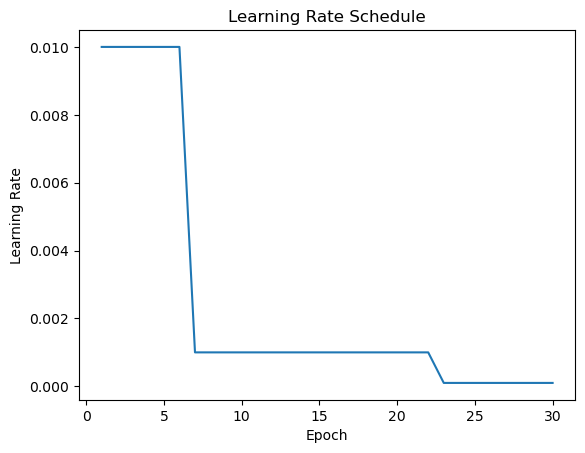

In [33]:
# Train the model
train(model=resnet_model, device=device, train_loader=train_loader, 
      val_loader=val_loader, criterion=criterion, optimizer=optimizer, 
      scheduler=scheduler, num_epochs=num_epochs)

In [35]:
# Save the model to a file
torch.save(resnet_model.state_dict(), 'Plant_Resnet_Model_final_30.pth')

# PREDICTING WITH RESNET

In [36]:
# Load the saved model state dictionary
resnet_model.load_state_dict(torch.load('Plant_Resnet_Model_final_30.pth'))

<All keys matched successfully>

In [37]:

true_labels = []
predicted_labels = []

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, 'test', img_name)
    img = Image.open(img_path)
    img_tensor = transforms.ToTensor()(img)
    true_label = img_name
    predicted_label = predict_image(img_tensor, resnet_model)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


# Create a table with the results
results_table = []
for true_label, predicted_label in zip(true_labels, predicted_labels):
    results_table.append([true_label, predicted_label])

# Print the table
headers = ['True Label', 'Predicted Label']
print(tabulate(results_table, headers=headers, tablefmt='grid'))

+----------------------------+----------------------------------------+
| True Label                 | Predicted Label                        |
+============================+========================================+
| AppleCedarRust1.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust2.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust3.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust4.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleScab1.JPG             | Apple___Apple_scab                     |
+----------------------------+----------------------------------------+
| AppleScab2.JPG             | Apple___Apple_scab               

# EVALUATING RESNET

In [38]:
# Make predictions on the validation set
predictions, true_labels = predict(resnet_model, device, val_loader)

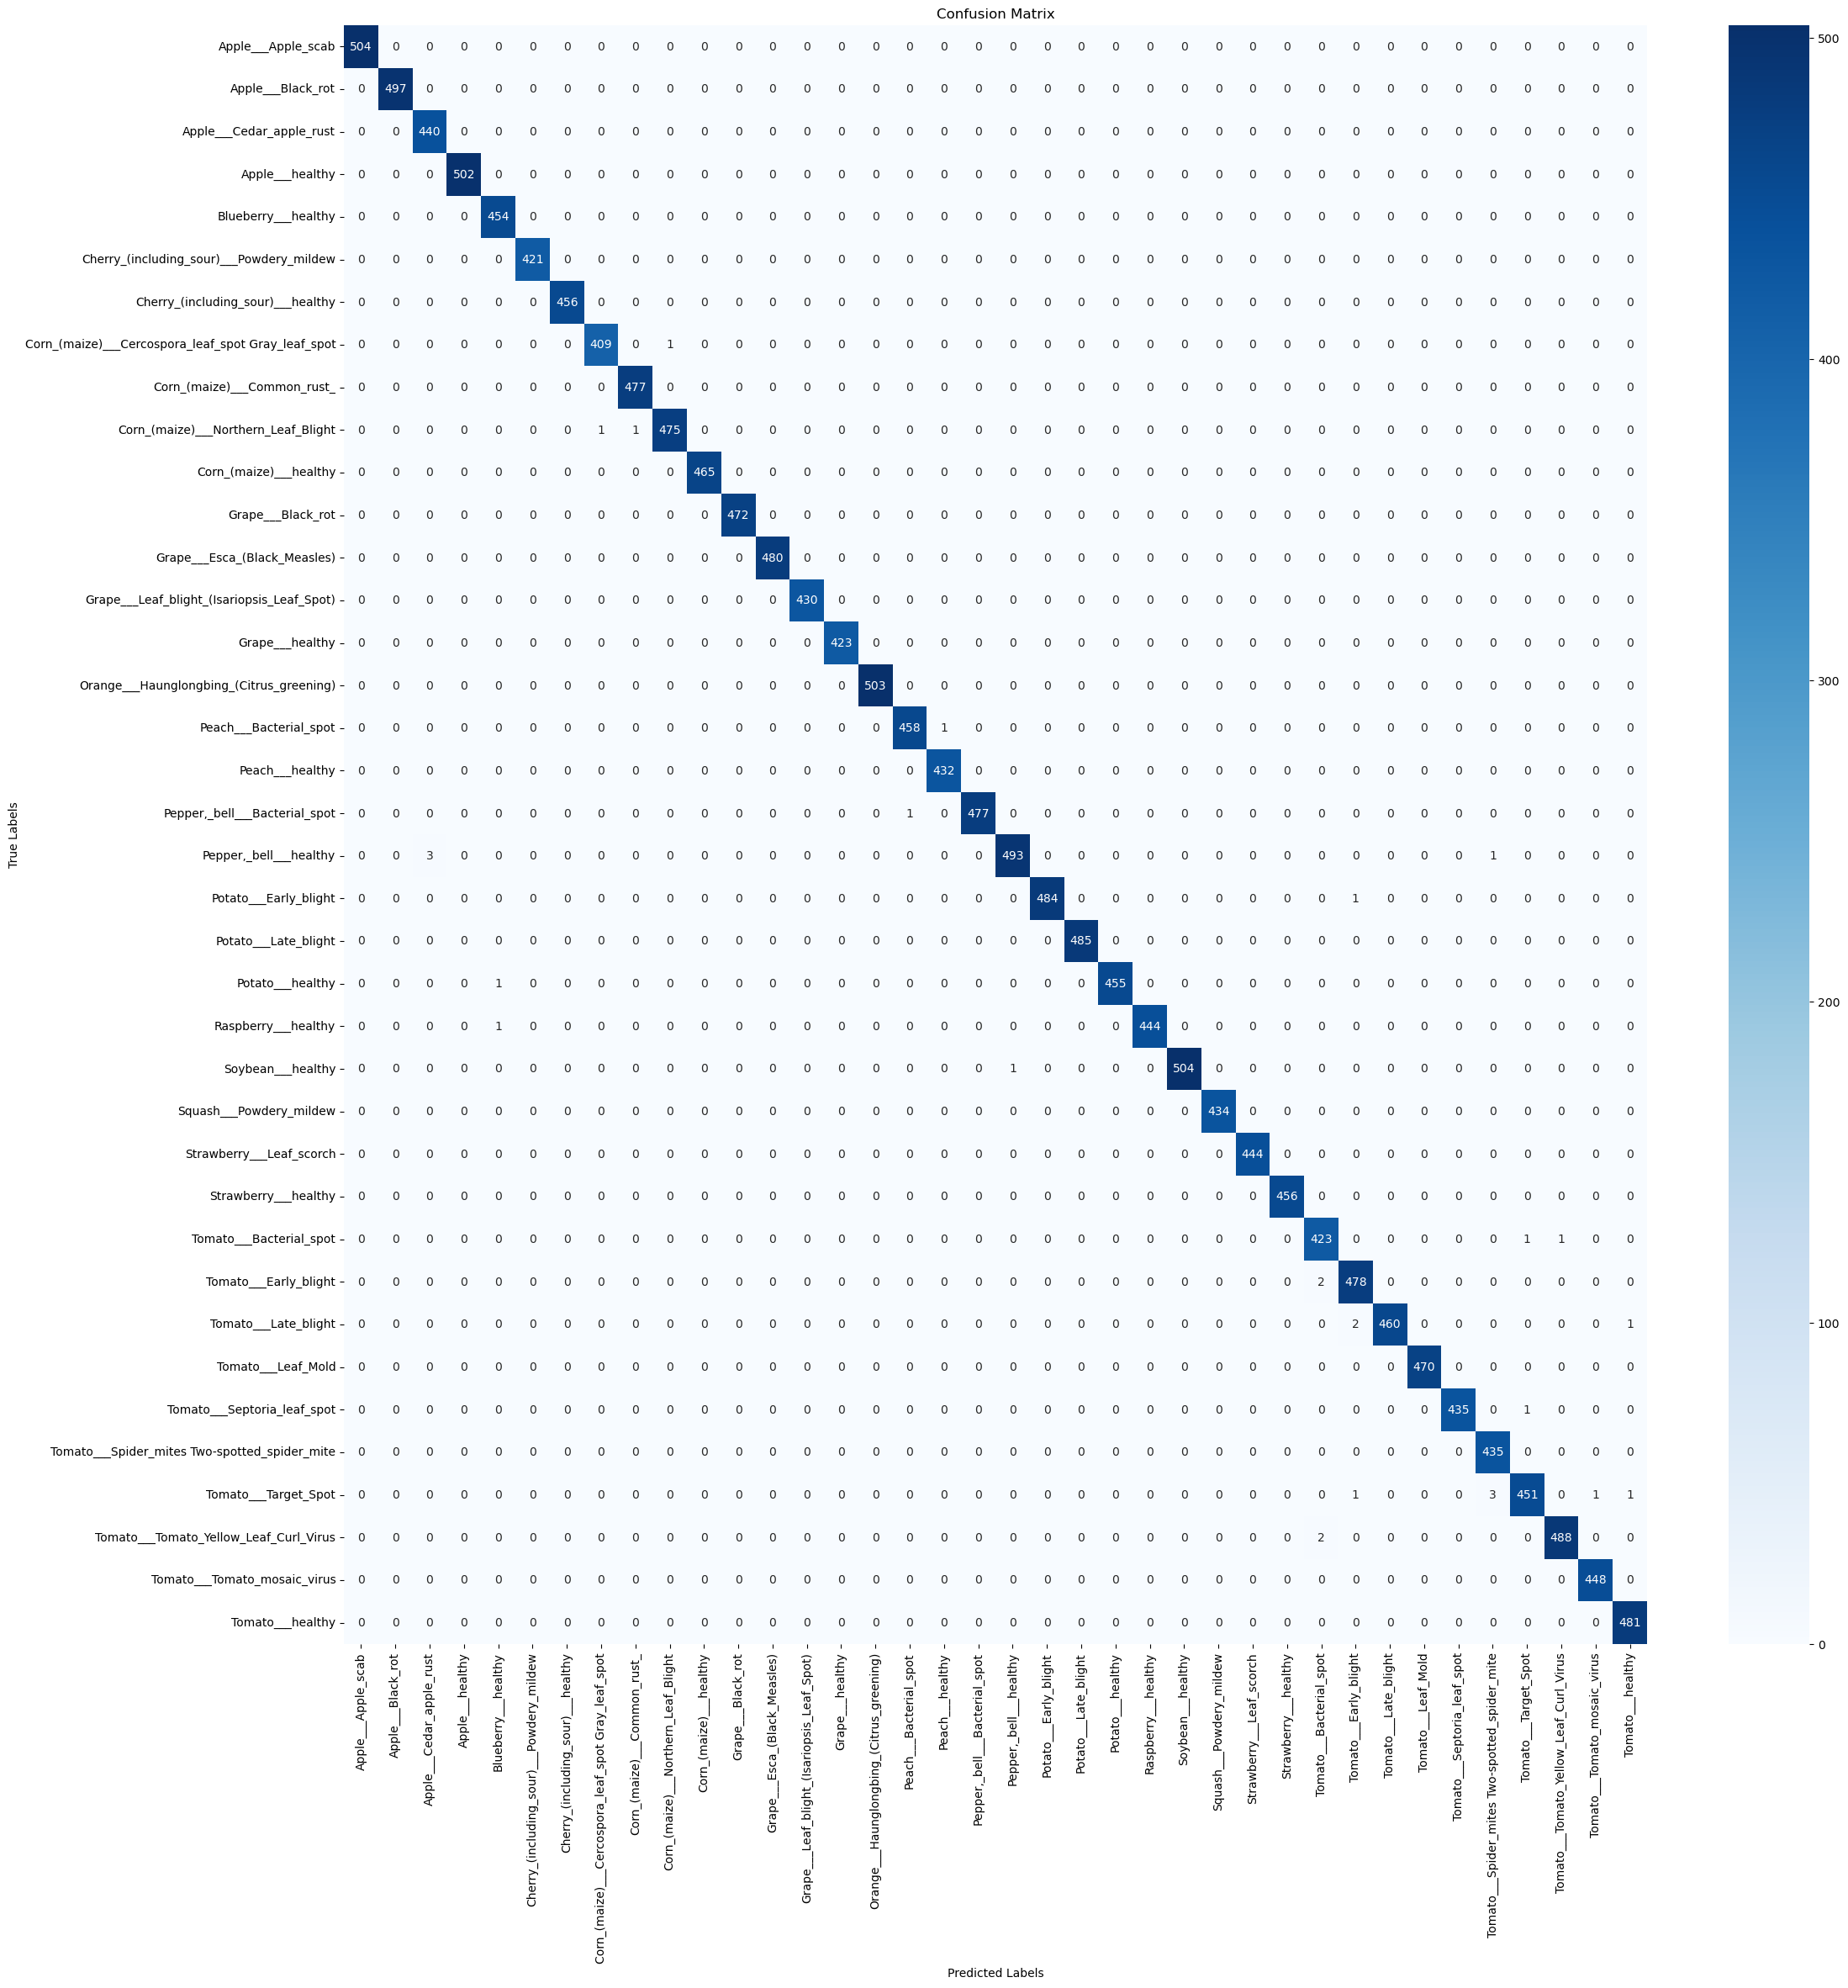

In [39]:


# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Get class names from train_dataset
class_names = train_dataset.classes

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

 #Convert the confusion matrix to a DataFrame for seaborn
confusion_mat_df = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)

# Create a heatmap using seaborn
plt.figure(figsize=(25, 25))
sns.heatmap(confusion_mat_df, annot=True, cmap='Blues', fmt='.0f')  # Specify fmt='.0f' to display labels as numbers


# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [41]:


# Calculate precision, recall, sensitivity, F1 score, support
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()

# Print the DataFrame
df_report

precision    recall  \
Apple___Apple_scab                                   1.000000  1.000000   
Apple___Black_rot                                    1.000000  1.000000   
Apple___Cedar_apple_rust                             0.993228  1.000000   
Apple___healthy                                      1.000000  1.000000   
Blueberry___healthy                                  0.995614  1.000000   
Cherry_(including_sour)___Powdery_mildew             1.000000  1.000000   
Cherry_(including_sour)___healthy                    1.000000  1.000000   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.997561  0.997561   
Corn_(maize)___Common_rust_                          0.997908  1.000000   
Corn_(maize)___Northern_Leaf_Blight                  0.997899  0.995807   
Corn_(maize)___healthy                               1.000000  1.000000   
Grape___Black_rot                                    1.000000  1.000000   
Grape___Esca_(Black_Measles)                         1.000000  1.000000   
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           1.000000  1.000000   
Grape___healthy                                      1.000000  1.000000   
Orange___Haunglongbing_(Citrus_greening)             1.000000  1.000000   
Peach___Bacterial_spot                               0.997821  0.997821   
Peach___healthy                                      0.997691  1.000000   
Pepper,_bell___Bacterial_spot                        1.000000  0.997908   
Pepper,_bell___healthy                               0.997976  0.991952   
Potato___Early_blight                                1.000000  0.997938   
Potato___Late_blight                                 1.000000  1.000000   
Potato___healthy                                     1.000000  0.997807   
Raspberry___healthy                                  1.000000  0.997753   
Soybean___healthy                                    1.000000  0.998020   
Squash___Powdery_mildew                              1.000000  1.000000   
Strawberry___Leaf_scorch                             1.000000  1.000000   
Strawberry___healthy                                 1.000000  1.000000   
Tomato___Bacterial_spot                              0.990632  0.995294   
Tomato___Early_blight                                0.991701  0.995833   
Tomato___Late_blight                                 1.000000  0.993521   
Tomato___Leaf_Mold                                   1.000000  1.000000   
Tomato___Septoria_leaf_spot                          1.000000  0.997706   
Tomato___Spider_mites Two-spotted_spider_mite        0.990888  1.000000   
Tomato___Target_Spot                                 0.995585  0.986871   
Tomato___Tomato_Yellow_Leaf_Curl_Virus               0.997955  0.995918   
Tomato___Tomato_mosaic_virus                         0.997773  1.000000   
Tomato___healthy                                     0.995859  1.000000   
accuracy                                             0.998350  0.998350   
macro avg                                            0.998318  0.998361   
weighted avg                                         0.998355  0.998350   

                                                    f1-score      support  
Apple___Apple_scab                                  1.000000    504.00000  
Apple___Black_rot                                   1.000000    497.00000  
Apple___Cedar_apple_rust                            0.996602    440.00000  
Apple___healthy                                     1.000000    502.00000  
Blueberry___healthy                                 0.997802    454.00000  
Cherry_(including_sour)___Powdery_mildew            1.000000    421.00000  
Cherry_(including_sour)___healthy                   1.000000    456.00000  
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  0.997561    410.00000  
Corn_(maize)___Common_rust_                         0.998953    477.00000  
Corn_(maize)___Northern_Leaf_Blight                 0.996852    477.00000  
Corn_(maize)___healthy                              1.000000    4

In [42]:


# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, F1 score, support (weighted avg)
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Calculate macro avg
macro_precision, macro_recall, macro_f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')

# Print the metrics
print("Accuracy:", accuracy)
print("Weighted Avg - Precision:", precision)
print("Weighted Avg - Recall:", recall)
print("Weighted Avg - F1 Score:", f1_score)
print("Macro Avg - Precision:", macro_precision)
print("Macro Avg - Recall:", macro_recall)
print("Macro Avg - F1 Score:", macro_f1_score)

Accuracy: 0.9983496471659459
Weighted Avg - Precision: 0.9983546493748463
Weighted Avg - Recall: 0.9983496471659459
Weighted Avg - F1 Score: 0.9983494825759406
Macro Avg - Precision: 0.9983182023292968
Macro Avg - Recall: 0.9983608037634089
Macro Avg - F1 Score: 0.9983367985596964


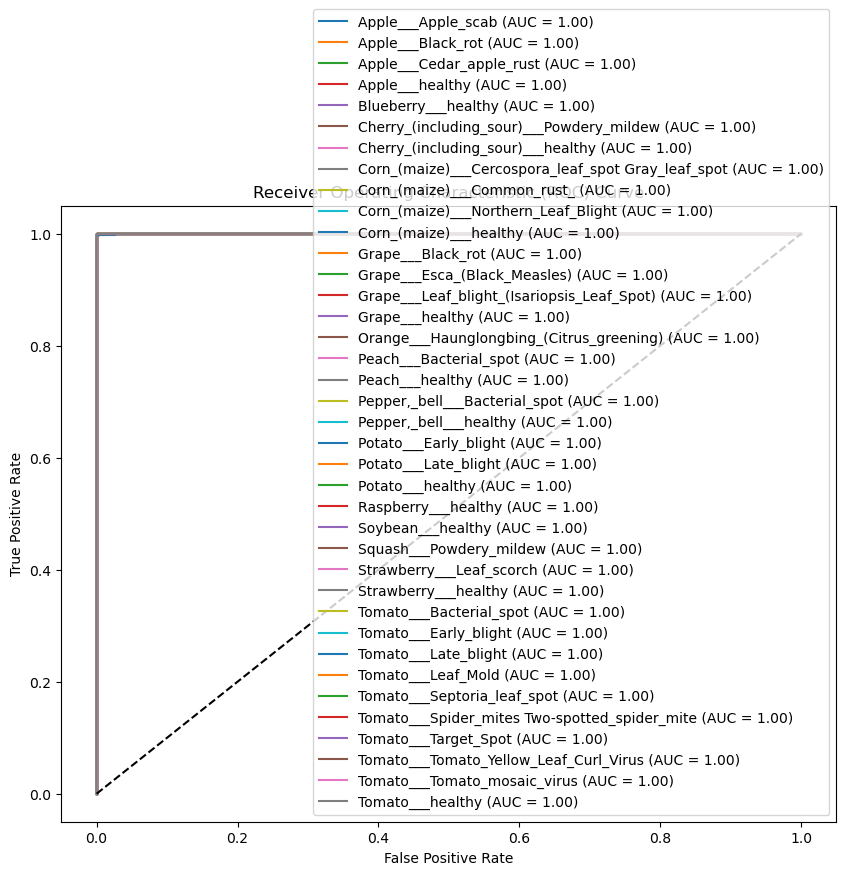

In [43]:


# Calculate probabilities for each class
probs = []
true_labels = []

with torch.no_grad():
    for data, targets in val_loader:
        data = data.to(device)
        outputs = resnet_model(data)
        probs_batch = torch.nn.functional.softmax(outputs, dim=1)
        probs.extend(probs_batch.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

probs = np.array(probs)
true_labels = np.array(true_labels)

# Calculate one-hot encoded true labels
one_hot_labels = np.eye(len(class_names))[true_labels]

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], probs[:, i])
    roc_auc[i] = roc_auc_score(one_hot_labels[:, i], probs[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the line of linearity
plt.plot([0, 1], [0, 1], 'k--')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## MOBILENET PRETRAINED MODEL

In [32]:

from torchvision.models import mobilenet_v2
plant_mobilenet = mobilenet_v2(pretrained=True)
num_features = plant_mobilenet.classifier[1].in_features


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 134MB/s]


In [33]:
num_classes = len(train_dataset.classes)
num_color_channels = 3

plant_mobilenet.classifier[1] = nn.Linear(num_features, num_classes * num_color_channels)

In [34]:

plant_mobilenet = plant_mobilenet.to(device)
# plant_mobilenet = plant_mobilenet.to(device)

In [35]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(plant_mobilenet.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [56]:
learning_rate = 0.01
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(plant_mobilenet.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [ ]:
# Train the model
train(model=plant_mobilenet, device=device, train_loader=train_loader, 
      val_loader=val_loader, criterion=criterion, optimizer=optimizer, 
      scheduler=scheduler, num_epochs=num_epochs)

Epoch [1/30]
Train Loss: 1.9634, Train Accuracy: 40.95%
Val Loss: 1.6582, Val Accuracy: 52.35%

Learning Rate: 0.010000

Epoch [2/30]
Train Loss: 0.7926, Train Accuracy: 74.34%
Val Loss: 0.6159, Val Accuracy: 80.27%

Learning Rate: 0.010000

Epoch [3/30]
Train Loss: 0.4731, Train Accuracy: 84.69%
Val Loss: 0.4168, Val Accuracy: 86.04%

Learning Rate: 0.010000

Epoch [4/30]
Train Loss: 0.3450, Train Accuracy: 88.65%
Val Loss: 0.8279, Val Accuracy: 78.21%

Learning Rate: 0.010000

Epoch [5/30]
Train Loss: 0.2675, Train Accuracy: 91.21%
Val Loss: 0.6689, Val Accuracy: 81.91%

Learning Rate: 0.010000

Epoch [6/30]
Train Loss: 0.2280, Train Accuracy: 92.55%
Val Loss: 0.4514, Val Accuracy: 86.65%

Learning Rate: 0.001000

Epoch [7/30]
Train Loss: 0.1024, Train Accuracy: 96.59%
Val Loss: 0.0511, Val Accuracy: 98.32%

Learning Rate: 0.001000

Epoch [8/30]
Train Loss: 0.0827, Train Accuracy: 97.30%
Val Loss: 0.0535, Val Accuracy: 98.22%

Learning Rate: 0.001000

Epoch [9/30]
Train Loss: 0.0756,

In [67]:
torch.save(plant_mobilenet.state_dict(), "plant_mobilenet_final_30.pth")

In [68]:
# Load the saved model state dictionary
plant_mobilenet.load_state_dict(torch.load('plant_mobilenet_final_30.pth'))

<All keys matched successfully>

# PREDICT WITH MOBILE NET

In [ ]:

true_labels = []
predicted_labels = []

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, 'test', img_name)
    img = Image.open(img_path)
    img_tensor = transforms.ToTensor()(img)
    true_label = img_name
    predicted_label = predict_image(img_tensor, plant_mobilenet)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


# Create a table with the results
results_table = []
for true_label, predicted_label in zip(true_labels, predicted_labels):
    results_table.append([true_label, predicted_label])

# Print the table
headers = ['True Label', 'Predicted Label']
print(tabulate(results_table, headers=headers, tablefmt='grid'))

In [61]:
# Make predictions on the validation set
predictions, true_labels = predict(plant_mobilenet, device, val_loader)

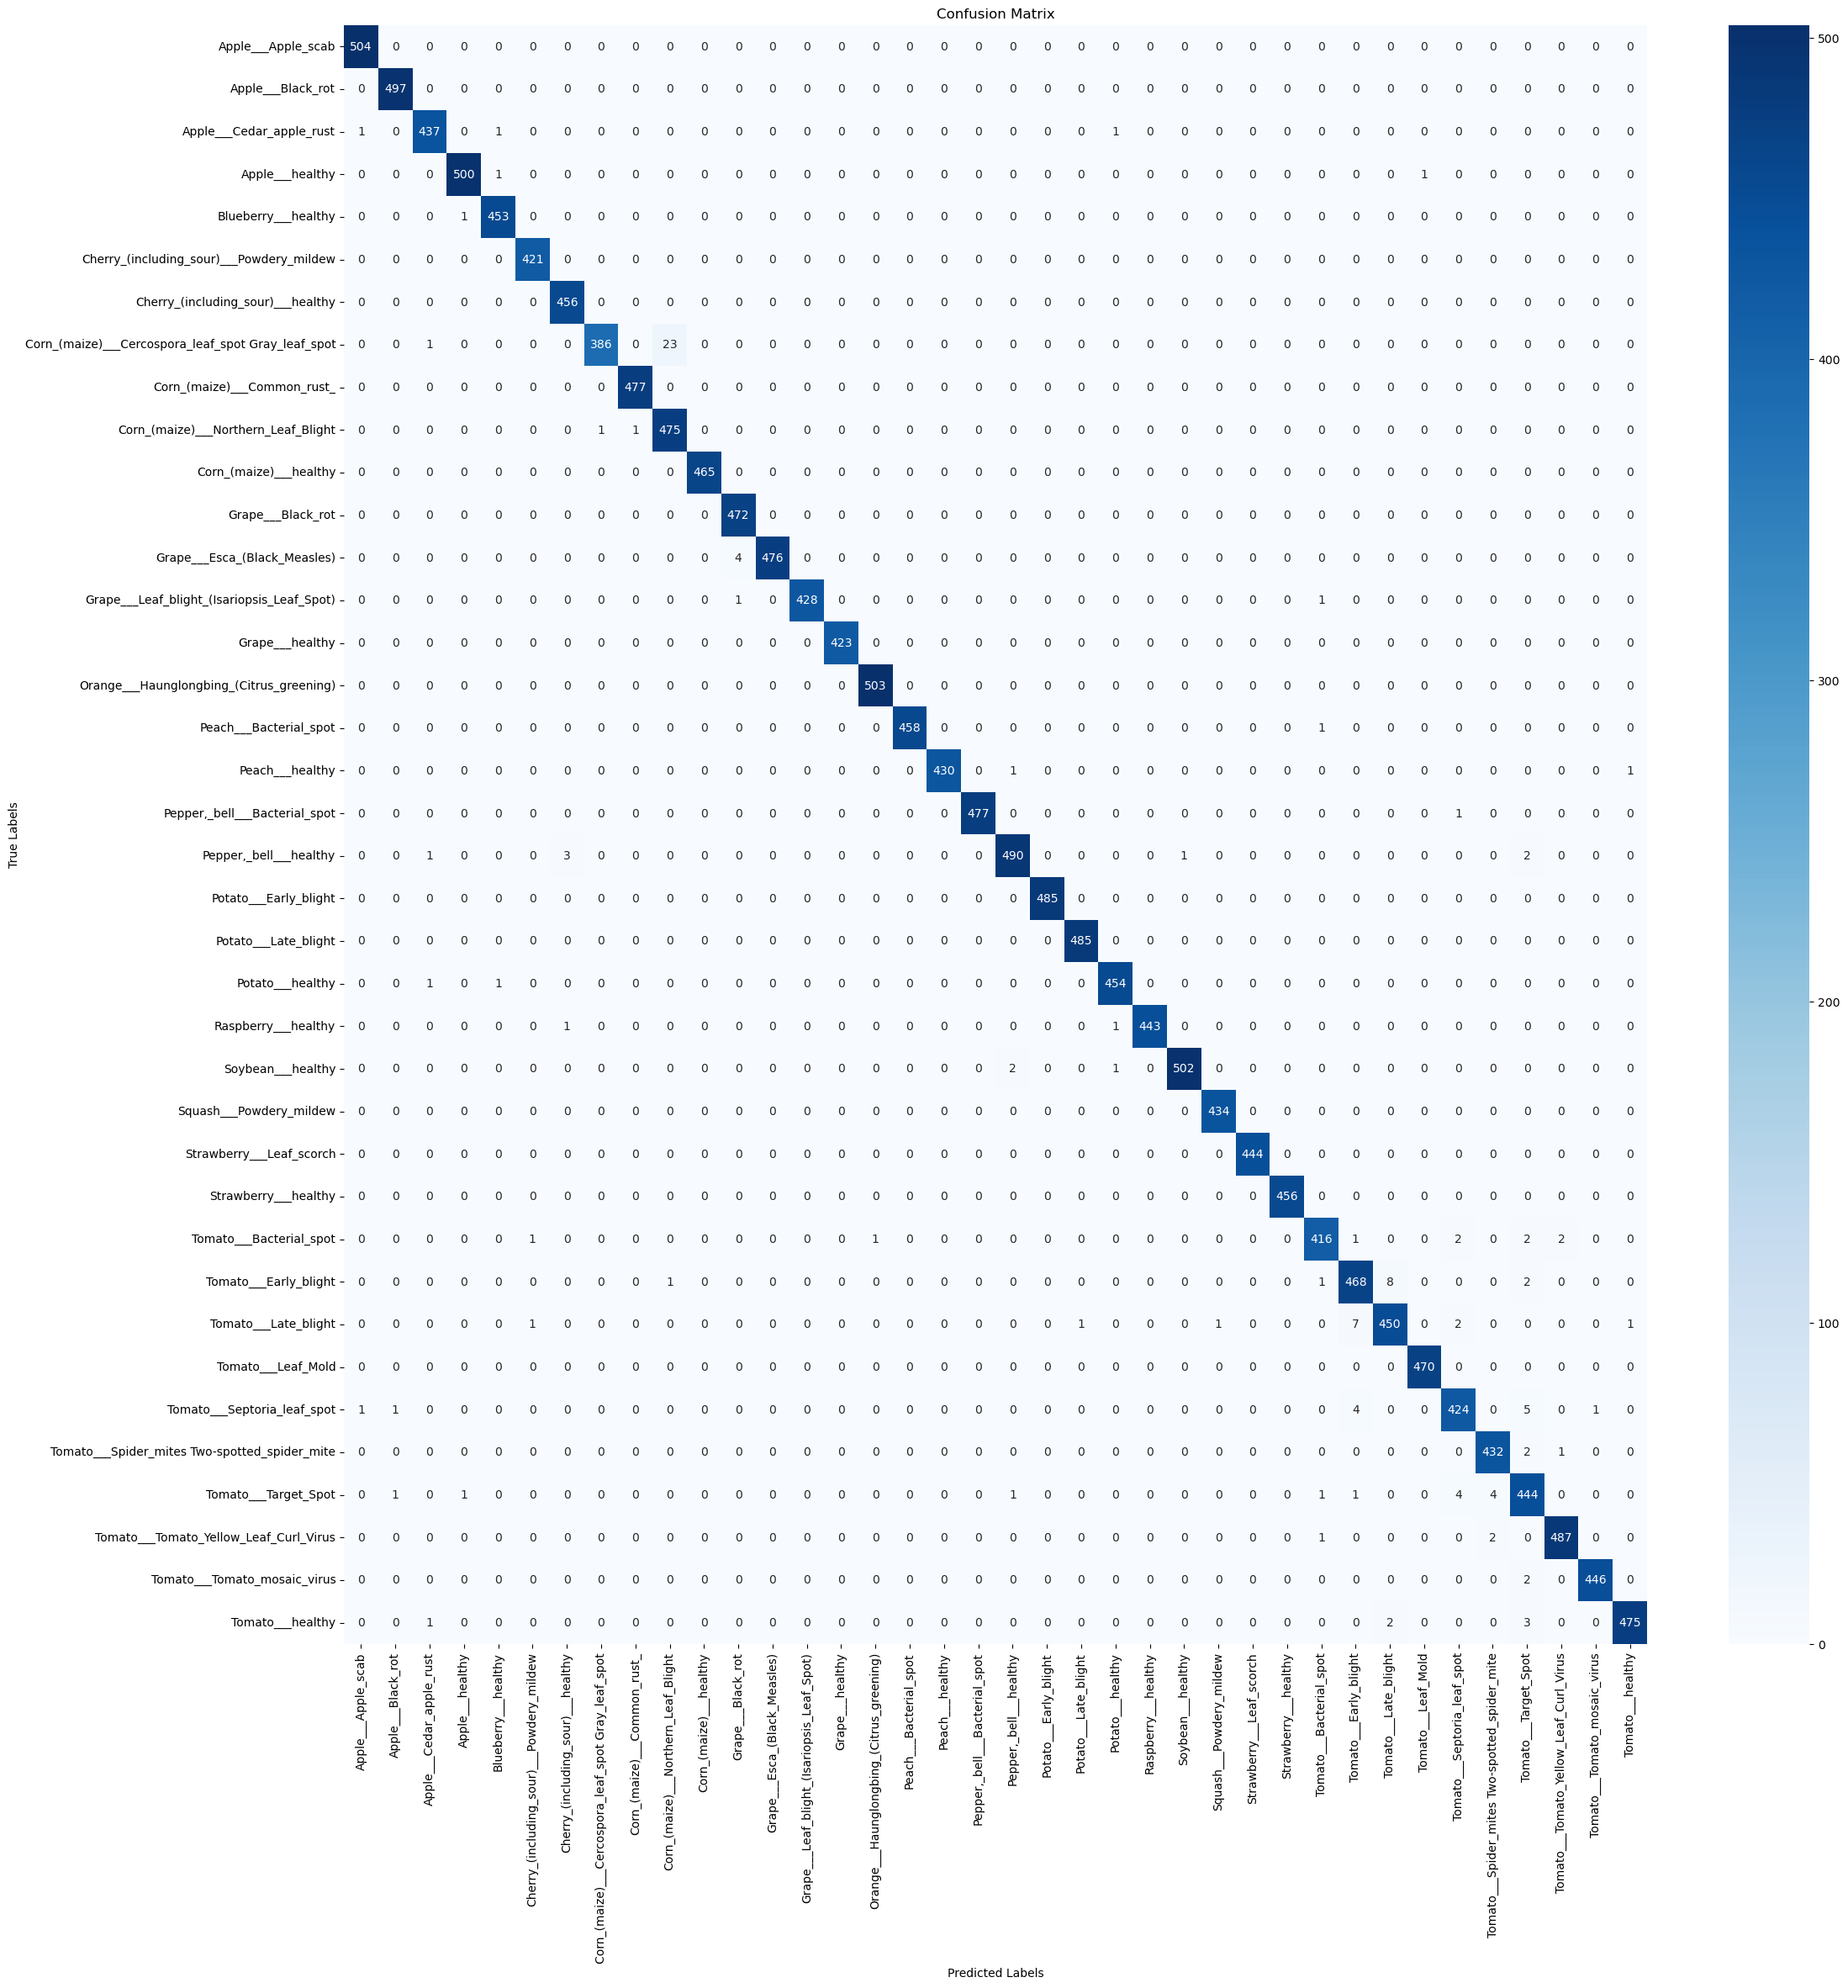

In [62]:


# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Get class names from train_dataset
class_names = train_dataset.classes

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

 #Convert the confusion matrix to a DataFrame for seaborn
confusion_mat_df = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)

# Create a heatmap using seaborn
plt.figure(figsize=(25, 25))
sns.heatmap(confusion_mat_df, annot=True, cmap='Blues', fmt='.0f')  # Specify fmt='.0f' to display labels as numbers


# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [63]:


# Calculate precision, recall, sensitivity, F1 score, support
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()

# Print the DataFrame
df_report

precision    recall  \
Apple___Apple_scab                                   0.996047  1.000000   
Apple___Black_rot                                    0.995992  1.000000   
Apple___Cedar_apple_rust                             0.990930  0.993182   
Apple___healthy                                      0.996016  0.996016   
Blueberry___healthy                                  0.993421  0.997797   
Cherry_(including_sour)___Powdery_mildew             0.995272  1.000000   
Cherry_(including_sour)___healthy                    0.991304  1.000000   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.997416  0.941463   
Corn_(maize)___Common_rust_                          0.997908  1.000000   
Corn_(maize)___Northern_Leaf_Blight                  0.951904  0.995807   
Corn_(maize)___healthy                               1.000000  1.000000   
Grape___Black_rot                                    0.989518  1.000000   
Grape___Esca_(Black_Measles)                         1.000000  0.991667   
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           1.000000  0.995349   
Grape___healthy                                      1.000000  1.000000   
Orange___Haunglongbing_(Citrus_greening)             0.998016  1.000000   
Peach___Bacterial_spot                               1.000000  0.997821   
Peach___healthy                                      1.000000  0.995370   
Pepper,_bell___Bacterial_spot                        1.000000  0.997908   
Pepper,_bell___healthy                               0.991903  0.985915   
Potato___Early_blight                                1.000000  1.000000   
Potato___Late_blight                                 0.997942  1.000000   
Potato___healthy                                     0.993435  0.995614   
Raspberry___healthy                                  1.000000  0.995506   
Soybean___healthy                                    0.998012  0.994059   
Squash___Powdery_mildew                              0.997701  1.000000   
Strawberry___Leaf_scorch                             1.000000  1.000000   
Strawberry___healthy                                 1.000000  1.000000   
Tomato___Bacterial_spot                              0.988124  0.978824   
Tomato___Early_blight                                0.972973  0.975000   
Tomato___Late_blight                                 0.978261  0.971922   
Tomato___Leaf_Mold                                   0.997877  1.000000   
Tomato___Septoria_leaf_spot                          0.979215  0.972477   
Tomato___Spider_mites Two-spotted_spider_mite        0.986301  0.993103   
Tomato___Target_Spot                                 0.961039  0.971554   
Tomato___Tomato_Yellow_Leaf_Curl_Virus               0.993878  0.993878   
Tomato___Tomato_mosaic_virus                         0.997763  0.995536   
Tomato___healthy                                     0.995807  0.987526   
accuracy                                             0.992659  0.992659   
macro avg                                            0.992736  0.992455   
weighted avg                                         0.992727  0.992659   

                                                    f1-score       support  
Apple___Apple_scab                                  0.998020    504.000000  
Apple___Black_rot                                   0.997992    497.000000  
Apple___Cedar_apple_rust                            0.992054    440.000000  
Apple___healthy                                     0.996016    502.000000  
Blueberry___healthy                                 0.995604    454.000000  
Cherry_(including_sour)___Powdery_mildew            0.997630    421.000000  
Cherry_(including_sour)___healthy                   0.995633    456.000000  
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  0.968632    410.000000  
Corn_(maize)___Common_rust_                         0.998953    477.000000  
Corn_(maize)___Northern_Leaf_Blight                 0.973361    477.000000  
Corn_(maize)___healthy                              1.

In [64]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, F1 score, support (weighted avg)
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Calculate macro avg
macro_precision, macro_recall, macro_f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')

# Print the metrics
print("Accuracy:", accuracy)
print("Weighted Avg - Precision:", precision)
print("Weighted Avg - Recall:", recall)
print("Weighted Avg - F1 Score:", f1_score)
print("Macro Avg - Precision:", macro_precision)
print("Macro Avg - Recall:", macro_recall)
print("Macro Avg - F1 Score:", macro_f1_score)

Accuracy: 0.9926587753243797
Weighted Avg - Precision: 0.9927265636828952
Weighted Avg - Recall: 0.9926587753243797
Weighted Avg - F1 Score: 0.9926545105317348
Macro Avg - Precision: 0.9927361687388828
Macro Avg - Recall: 0.9924551192633815
Macro Avg - F1 Score: 0.9925554461621046


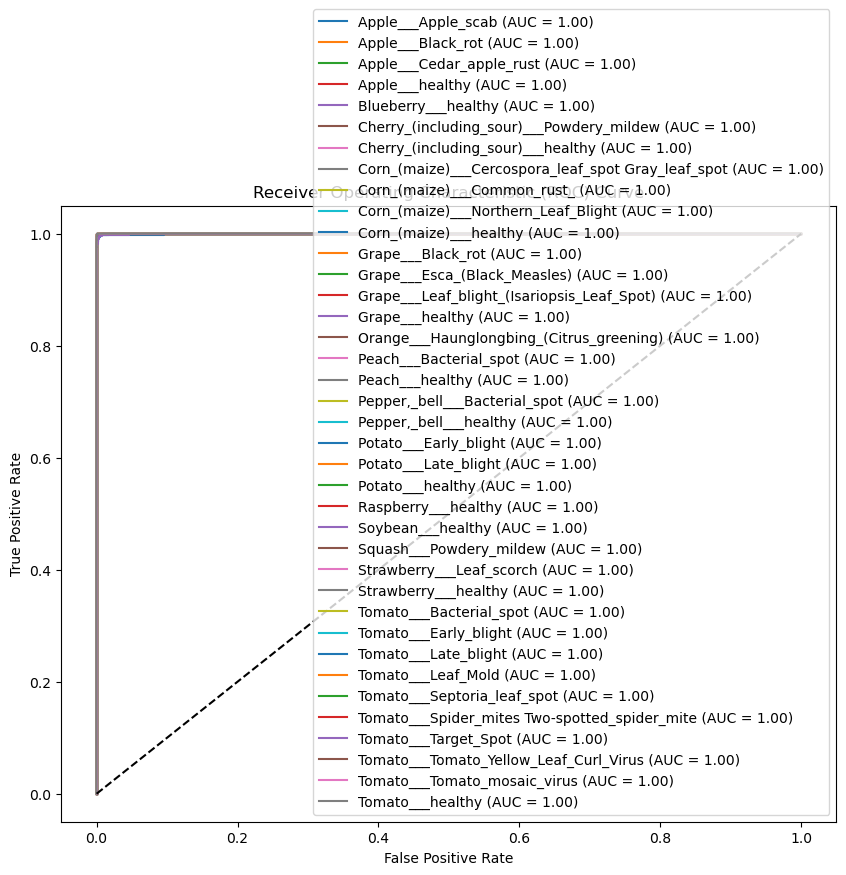

In [65]:


# Calculate probabilities for each class
probs = []
true_labels = []

with torch.no_grad():
    for data, targets in val_loader:
        data = data.to(device)
        outputs = plant_mobilenet(data)
        probs_batch = torch.nn.functional.softmax(outputs, dim=1)
        probs.extend(probs_batch.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

probs = np.array(probs)
true_labels = np.array(true_labels)

# Calculate one-hot encoded true labels
one_hot_labels = np.eye(len(class_names))[true_labels]

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], probs[:, i])
    roc_auc[i] = roc_auc_score(one_hot_labels[:, i], probs[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the line of linearity
plt.plot([0, 1], [0, 1], 'k--')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

## EFFICIENTNET

In [15]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0fa52bcfc0dd25a59922089abbd498c4760d4db3c0b7b8a838a80fa9279af426
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [17]:
import torch.nn as nn
from torchvision.models import efficientnet_b2

num_classes = len(train_dataset.classes)
num_color_channels = 3

plant_efficientnet = efficientnet_b2(pretrained=True)

classifier = list(plant_efficientnet.classifier.children())[-1]
in_features = classifier.in_features

plant_efficientnet.classifier[-1] = nn.Linear(in_features, num_classes * num_color_channels)
plant_efficientnet = plant_efficientnet.to(device)


In [18]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(plant_efficientnet.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [20]:
learning_rate = 0.01
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(plant_efficientnet.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

Epoch [1/30]
Train Loss: 0.9375, Train Accuracy: 71.48%
Val Loss: 0.5274, Val Accuracy: 84.18%

Learning Rate: 0.010000

Epoch [2/30]
Train Loss: 0.3654, Train Accuracy: 88.57%
Val Loss: 0.5150, Val Accuracy: 86.20%

Learning Rate: 0.010000

Epoch [3/30]
Train Loss: 0.2782, Train Accuracy: 91.42%
Val Loss: 0.1577, Val Accuracy: 94.95%

Learning Rate: 0.010000

Epoch [4/30]
Train Loss: 0.2282, Train Accuracy: 93.00%
Val Loss: 0.3044, Val Accuracy: 91.11%

Learning Rate: 0.010000

Epoch [5/30]
Train Loss: 0.1980, Train Accuracy: 93.96%
Val Loss: 0.2472, Val Accuracy: 93.15%

Learning Rate: 0.010000

Epoch [6/30]
Train Loss: 0.1756, Train Accuracy: 94.64%
Val Loss: 0.1986, Val Accuracy: 94.95%

Learning Rate: 0.001000

Epoch [7/30]
Train Loss: 0.0586, Train Accuracy: 98.10%
Val Loss: 0.0390, Val Accuracy: 98.76%

Learning Rate: 0.001000

Epoch [9/30]
Train Loss: 0.0351, Train Accuracy: 98.79%
Val Loss: 0.0285, Val Accuracy: 99.11%

Learning Rate: 0.001000

Epoch [10/30]
Train Loss: 0.0316

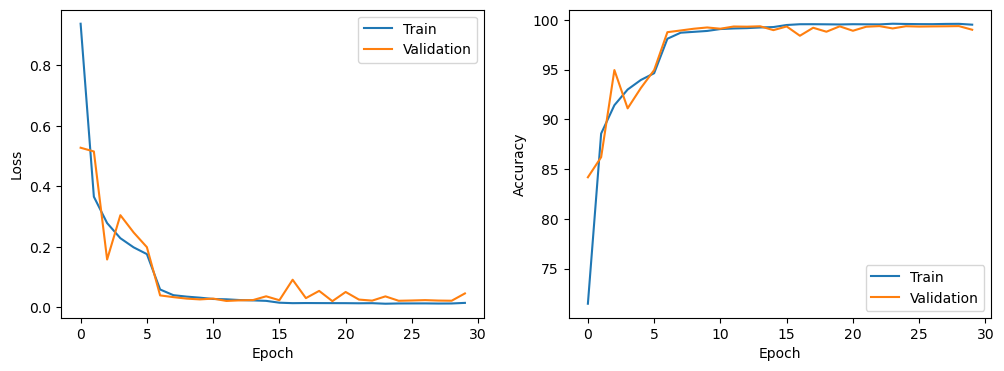

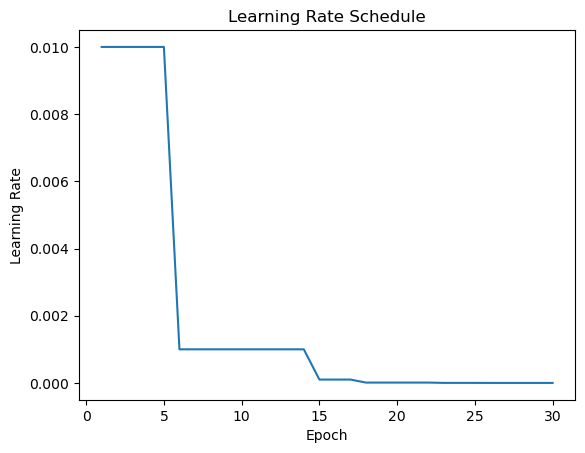

In [21]:
# Train the model
train(model=plant_efficientnet, device=device, train_loader=train_loader, 
      val_loader=val_loader, criterion=criterion, optimizer=optimizer, 
      scheduler=scheduler, num_epochs=num_epochs)

In [23]:
torch.save(plant_efficientnet.state_dict(), "plant_efficientnet_final_30.pth")

In [24]:
# Load the saved model state dictionary
plant_efficientnet.load_state_dict(torch.load('plant_efficientnet_final_30.pth'))

<All keys matched successfully>

In [25]:

true_labels = []
predicted_labels = []

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, 'test', img_name)
    img = Image.open(img_path)
    img_tensor = transforms.ToTensor()(img)
    true_label = img_name
    predicted_label = predict_image(img_tensor, plant_efficientnet)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


# Create a table with the results
results_table = []
for true_label, predicted_label in zip(true_labels, predicted_labels):
    results_table.append([true_label, predicted_label])

# Print the table
headers = ['True Label', 'Predicted Label']
print(tabulate(results_table, headers=headers, tablefmt='grid'))

+----------------------------+----------------------------------------+
| True Label                 | Predicted Label                        |
+============================+========================================+
| AppleCedarRust1.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust2.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust3.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleCedarRust4.JPG        | Apple___Cedar_apple_rust               |
+----------------------------+----------------------------------------+
| AppleScab1.JPG             | Apple___Apple_scab                     |
+----------------------------+----------------------------------------+
| AppleScab2.JPG             | Apple___Apple_scab               

In [26]:
# Make predictions on the validation set
predictions, true_labels = predict(plant_efficientnet, device, val_loader)

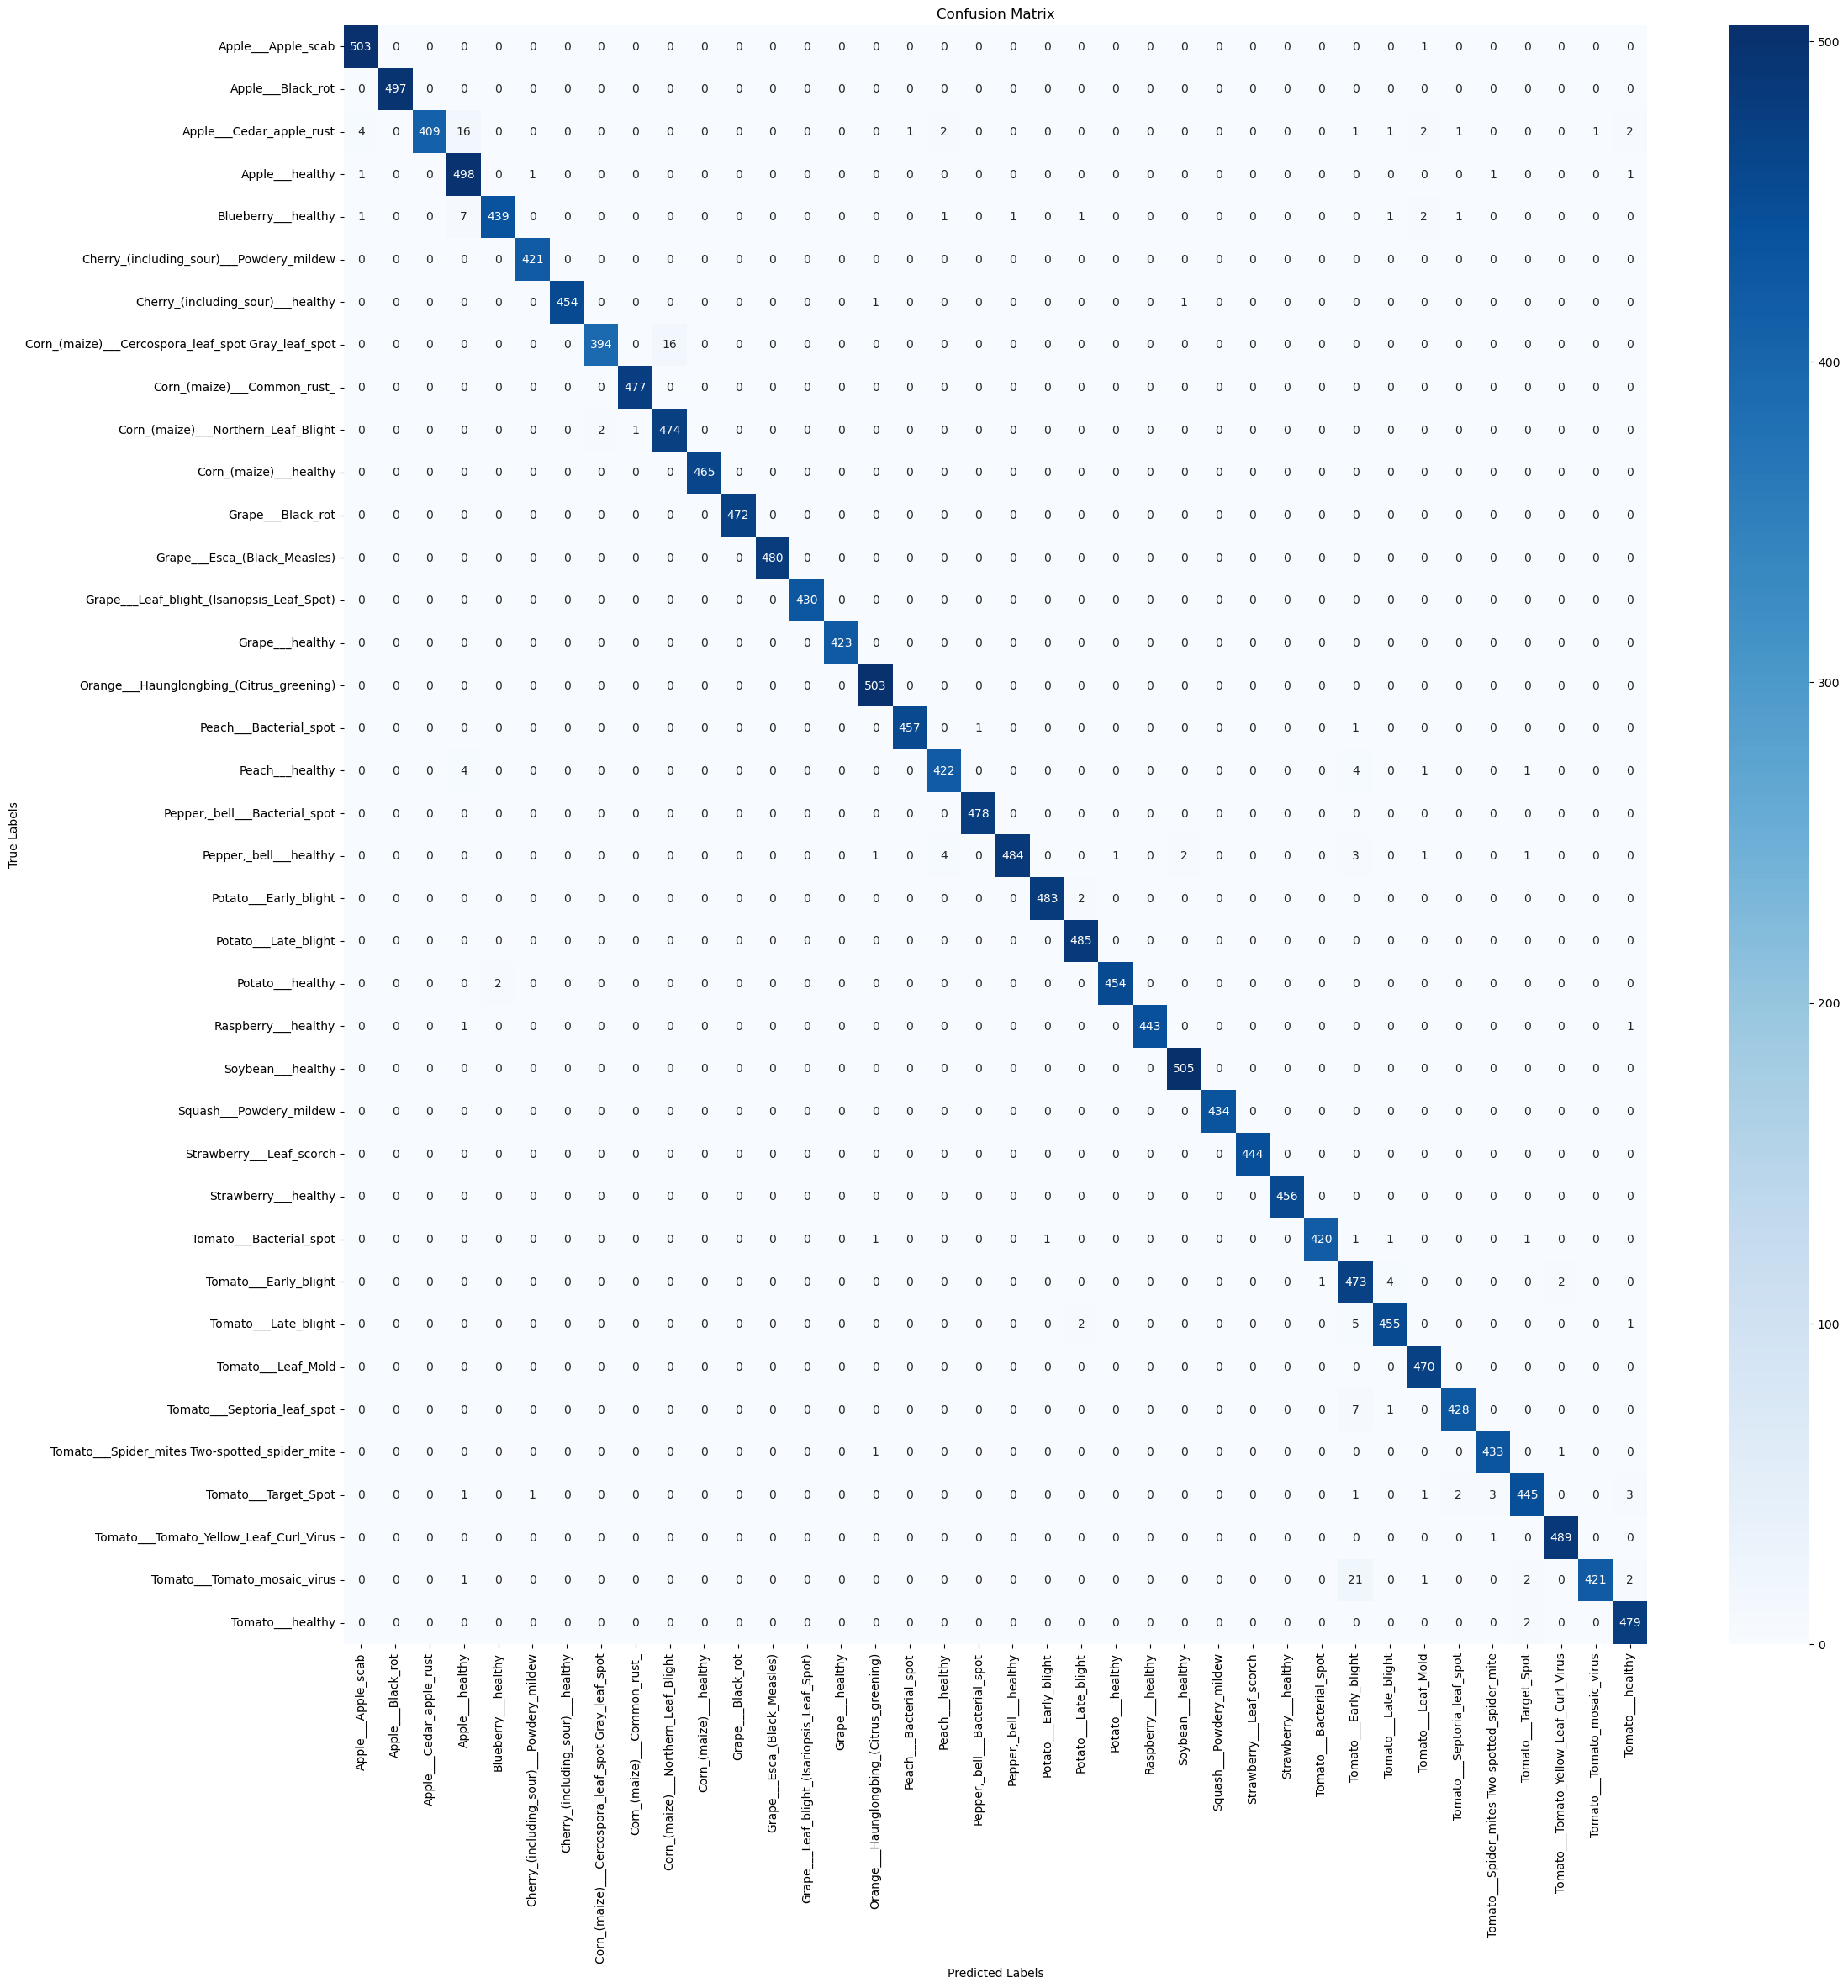

In [27]:
# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Get class names from train_dataset
class_names = train_dataset.classes

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

 #Convert the confusion matrix to a DataFrame for seaborn
confusion_mat_df = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)

# Create a heatmap using seaborn
plt.figure(figsize=(25, 25))
sns.heatmap(confusion_mat_df, annot=True, cmap='Blues', fmt='.0f')  # Specify fmt='.0f' to display labels as numbers


# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [28]:

# Calculate precision, recall, sensitivity, F1 score, support
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()

# Print the DataFrame
df_report

precision    recall  \
Apple___Apple_scab                                   0.988212  0.998016   
Apple___Black_rot                                    1.000000  1.000000   
Apple___Cedar_apple_rust                             1.000000  0.929545   
Apple___healthy                                      0.943182  0.992032   
Blueberry___healthy                                  0.995465  0.966960   
Cherry_(including_sour)___Powdery_mildew             0.995272  1.000000   
Cherry_(including_sour)___healthy                    1.000000  0.995614   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.994949  0.960976   
Corn_(maize)___Common_rust_                          0.997908  1.000000   
Corn_(maize)___Northern_Leaf_Blight                  0.967347  0.993711   
Corn_(maize)___healthy                               1.000000  1.000000   
Grape___Black_rot                                    1.000000  1.000000   
Grape___Esca_(Black_Measles)                         1.000000  1.000000   
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           1.000000  1.000000   
Grape___healthy                                      1.000000  1.000000   
Orange___Haunglongbing_(Citrus_greening)             0.992110  1.000000   
Peach___Bacterial_spot                               0.997817  0.995643   
Peach___healthy                                      0.983683  0.976852   
Pepper,_bell___Bacterial_spot                        0.997912  1.000000   
Pepper,_bell___healthy                               0.997938  0.973843   
Potato___Early_blight                                0.997934  0.995876   
Potato___Late_blight                                 0.989796  1.000000   
Potato___healthy                                     0.997802  0.995614   
Raspberry___healthy                                  1.000000  0.995506   
Soybean___healthy                                    0.994094  1.000000   
Squash___Powdery_mildew                              1.000000  1.000000   
Strawberry___Leaf_scorch                             1.000000  1.000000   
Strawberry___healthy                                 1.000000  1.000000   
Tomato___Bacterial_spot                              0.997625  0.988235   
Tomato___Early_blight                                0.914894  0.985417   
Tomato___Late_blight                                 0.982721  0.982721   
Tomato___Leaf_Mold                                   0.981211  1.000000   
Tomato___Septoria_leaf_spot                          0.990741  0.981651   
Tomato___Spider_mites Two-spotted_spider_mite        0.988584  0.995402   
Tomato___Target_Spot                                 0.984513  0.973742   
Tomato___Tomato_Yellow_Leaf_Curl_Virus               0.993902  0.997959   
Tomato___Tomato_mosaic_virus                         0.997630  0.939732   
Tomato___healthy                                     0.979550  0.995842   
accuracy                                             0.990041  0.990041   
macro avg                                            0.990600  0.989760   
weighted avg                                         0.990337  0.990041   

                                                    f1-score       support  
Apple___Apple_scab                                  0.993090    504.000000  
Apple___Black_rot                                   1.000000    497.000000  
Apple___Cedar_apple_rust                            0.963486    440.000000  
Apple___healthy                                     0.966990    502.000000  
Blueberry___healthy                                 0.981006    454.000000  
Cherry_(including_sour)___Powdery_mildew            0.997630    421.000000  
Cherry_(including_sour)___healthy                   0.997802    456.000000  
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  0.977667    410.000000  
Corn_(maize)___Common_rust_                         0.998953    477.000000  
Corn_(maize)___Northern_Leaf_Blight                 0.980352    477.000000  
Corn_(maize)___healthy                              1.

In [29]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, F1 score, support (weighted avg)
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Calculate macro avg
macro_precision, macro_recall, macro_f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')

# Print the metrics
print("Accuracy:", accuracy)
print("Weighted Avg - Precision:", precision)
print("Weighted Avg - Recall:", recall)
print("Weighted Avg - F1 Score:", f1_score)
print("Macro Avg - Precision:", macro_precision)
print("Macro Avg - Recall:", macro_recall)
print("Macro Avg - F1 Score:", macro_f1_score)

Accuracy: 0.9900409742772592
Weighted Avg - Precision: 0.9903373164259532
Weighted Avg - Recall: 0.9900409742772592
Weighted Avg - F1 Score: 0.9900509132800626
Macro Avg - Precision: 0.9905998422509219
Macro Avg - Recall: 0.9897602520360099
Macro Avg - F1 Score: 0.9900417388611134


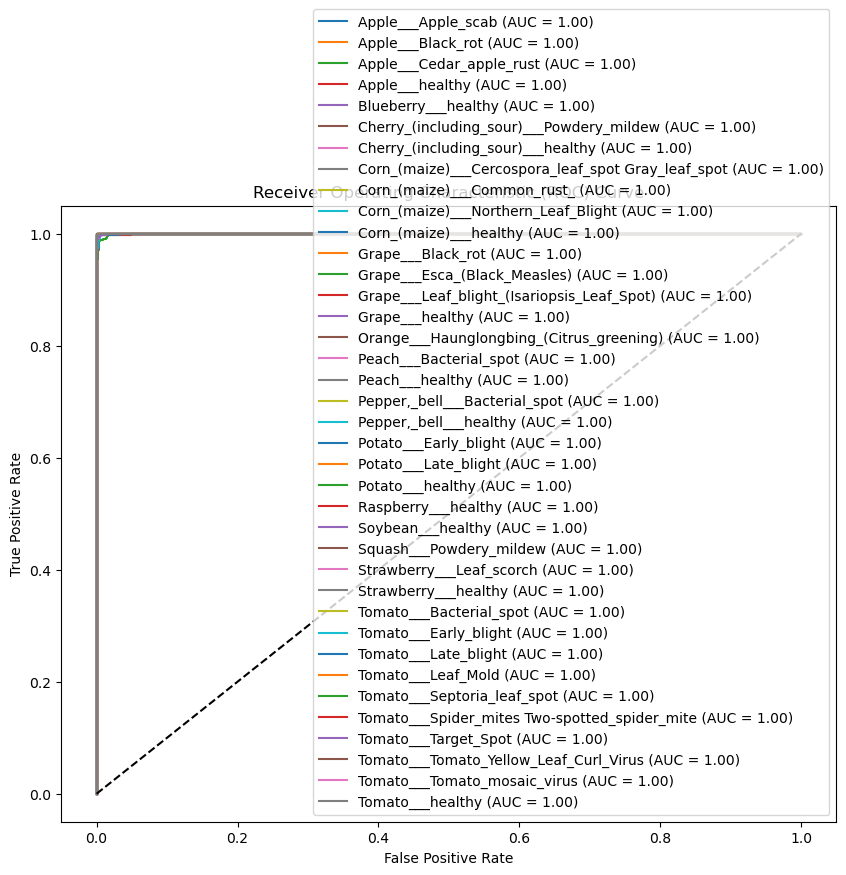

In [30]:
# Calculate probabilities for each class
probs = []
true_labels = []

with torch.no_grad():
    for data, targets in val_loader:
        data = data.to(device)
        outputs = plant_efficientnet(data)
        probs_batch = torch.nn.functional.softmax(outputs, dim=1)
        probs.extend(probs_batch.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

probs = np.array(probs)
true_labels = np.array(true_labels)

# Calculate one-hot encoded true labels
one_hot_labels = np.eye(len(class_names))[true_labels]

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], probs[:, i])
    roc_auc[i] = roc_auc_score(one_hot_labels[:, i], probs[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the line of linearity
plt.plot([0, 1], [0, 1], 'k--')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()